---
title: "Post 3 - Auditing Bias in Machine Learning Models"
author: Col McDermott
date: "03-12-2025"
description: "An introductory examination of racial gender bias in a predictive ML model (predicting employment)."
format: html
code-fold: true
execute:
  warning: false
  message: false
---

# Abstract

In this analysis, I explore the construction of a predictive classification model and subsequently examine the model’s properties and behavior to audit for bias.  Specifically, the model I constructed aims to predict the employment status of a given individual.  Following the refining process, the behavior, accuracy, and error rates of the model are investigated and compared across each racial group outlined in the data.  The purpose of this is to uncover any biases on the basis of race the model may be exercising when making predictions for certain individuals.  While the model is blind to racial identity during training, this does not eliminate the possibility that systemic racial biases are reflected in the model’s predictive behavior.  To audit for potential bias, the model is checked for three primary “fairness” criteria: calibration, error rate balance, and statistical parity.  In the search for bias, it is found that the refined model is relatively well-calibrated across each of the racial groups present in the data, but the model generally fails to satisfy the error-balance and statistical parity conditions of accepted “fairness”.  Ultimately, the model is shown to exhibit “unfair” (i.e. inconsistent) predictive behavior pertaining to the racial identity of individuals in the data.  The results of this introductory study highlight the crucial role of diligently investigating the presence of group-based bias and “unfairness” exercised by classification models even when such models are blind to the group identity.  Considering these findings in the context of employment prediction, this study serves as an example of how systemic biases perpetuated through an automated decision classifier can contribute and compound upon past injustices that have discriminantly affected individuals of certain racial identities more than others.

## Accessing the Data

In [20]:
# Includuing all additional imports
from sklearn.model_selection import cross_val_score, train_test_split
from folktables import ACSDataSource, BasicProblem
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

# Downloading ACS PUMS data for the state of Massachusetts - Code provided by Prof. Chodrow
STATE = "MA"
ds = ACSDataSource(survey_year = "2018", 
                            horizon = "1-Year", 
                            survey = "person")
ma = ds.get_data(states = [STATE], download = True)

*Including all additional imports*

The data for this study comes from an ACS (American Community Survey) data set.  Specifically, the data is from a 2018 PUMS (Public Use Microdata Sample) survey for the state of Massachusetts.  Each observation from this data set is an individual massachusetts resident who completed the 2018 PUMS survey.  The data is downloaded using the `ACSDataSource` class from the `folktables` package.

### Subsetting Variables - Extracting Relevant Features

In [21]:
vars = ["AGEP", "SCHL", "MAR", "RELP", "DIS", "ESP", "CIT", "MIG", "MIL", "ANC", "NATIVITY", "DEAR", "DEYE", "DREM", "SEX", "RAC1P", "ESR"]

Untouched, the data contains nearly 300 different features.  However, for this study, I will only be using a subset of the columns:

-   `AGEP`: Age (Range 0 - 99)
-   `SCHL`: Educational Attainment (Range 1 - 24)
-   `MAR`: Marital Status (Range 1 - 5)
-   `RELP`: Relationship to Householder (Range 1 - 17)
-   `DIS`: Disability Present (Binary)
-   `ESP`: Employment Status of Parents (Range 1 - 8)
-   `CIT`: Citizenship Status (Range 1 - 5)
-   `MIG`: Mobility Status - Lived in Specified Location 1 Year Ago (Range 1 - 3)
-   `MIL`: Military Service (Range 1 - 5)
-   `ANC`: Ancestry (Range 1 - 4, 8)
-   `NATIVITY`: Nativity (Binary)
-   `DEAR`: Hearing Difficulty (Binary)
-   `DEYE`: Vision Difficulty (Binary)
-   `DREM`: Cognitive Difficulty (Binary)
-   `SEX`: Sex (Binary)
-   `RAC1P`: Race (Range 1 - 9)
-   `ESR`: Employment Status (Range 1 - 6)
-   `PINCP`: Total Person Income (Integer Range of Income in US Dollars:  -19997 - 4209995)

## Model 1 - Predicting Employment Status

#### Data Preparation

In [22]:
# Filtering out employment status (target) and race variables
vars1 = [v for v in vars if v not in ["ESR", "RAC1P"]]

# Defining the predictive modeling task - Code provided by Prof. Chodrow
EmploymentProblem = BasicProblem(
    features = vars1,
    target = "ESR",
    target_transform = lambda x: x == 1,
    group = "RAC1P",
    preprocess = lambda x: x,
    postprocess = lambda x: np.nan_to_num(x, -1),
)
features, label, group = EmploymentProblem.df_to_numpy(ma)

# Test, train split procedure
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(features, label, group, test_size = 0.2, random_state = 69)

*Code above defines the predictive modeling task and constructs the training data for the employment prediction model.*

Before constructing the first predictive model, the predictive modeling task is defined.  Afterwards, a test-train-split procedure is conducted on the data to prepare it for model fitting.

#### General Descriptives

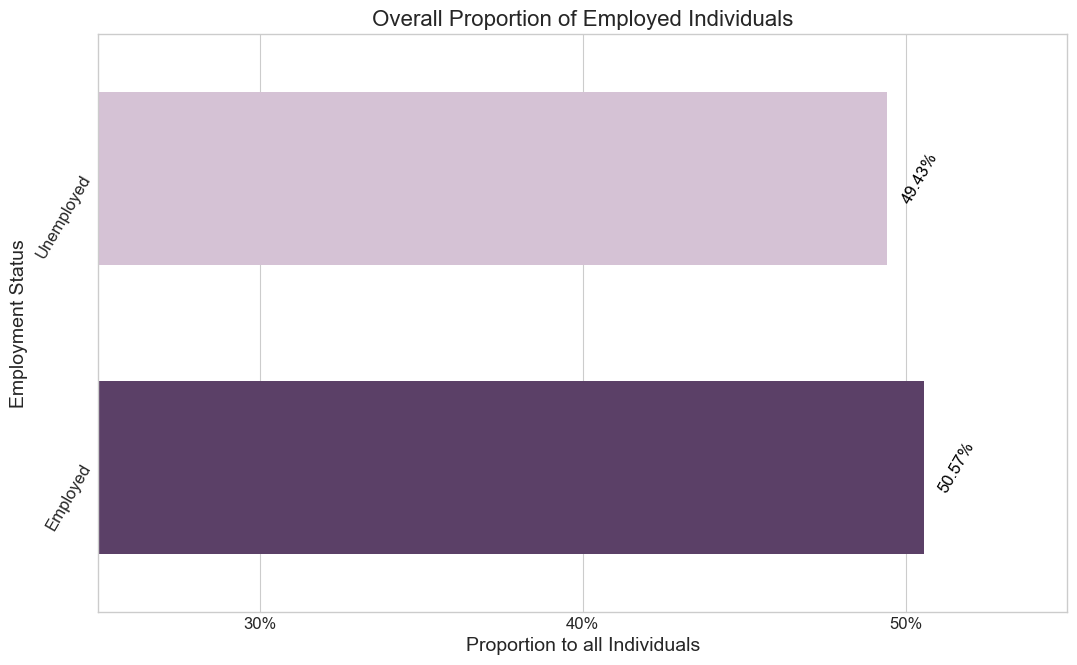

In [23]:
# Observing some general descriptives in the training data
train = pd.DataFrame(X_train, columns = vars1)
train["emp_status"] = y_train.astype(int)
train["race"] = group_train
train.dropna(inplace = True)

# Total number of individuals in the training data
n = train.shape[0]

# Proportion of employed individuals in the training data
emp_prop = train["emp_status"].mean()

# Proportion of employed individuals of each race
tot_emp = (train["emp_status"] == 1).sum()
race_prop_emp_tot = (train.groupby("race")["emp_status"].sum() / tot_emp) * 100

# Proportion of employed individuals within each race
race_prop_emp = train.groupby("race").aggregate({"emp_status": "mean"})
race_prop_emp["u_emp"] = 1 - race_prop_emp["emp_status"]

# Plotting proportion of employed individuals (total)
## Creating dataframe for plotting
emp_prop_tot = pd.DataFrame({
    "emp": ['Unemployed', 'Employed'],
    "prop": [1 - emp_prop, emp_prop]
})
fig, ax = plt.subplots(1, 1, figsize = (12.5, 7.5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.barplot(emp_prop_tot, x = "prop", y = "emp", hue = "prop", palette = ["#D8BFD8", "#5D3A6D"], legend = False, width = 0.6, ax = ax)
ax.set_title("Overall Proportion of Employed Individuals", fontsize = 16)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Unemployed", "Employed"], fontsize = 12, rotation = 60)
ax.set_xlim(0.25, 0.55)
ax.set_xticks([i / 10 for i in range(3, 6)])
ax.set_xticklabels([f"{i * 10}%" for i in range(3, 6)], fontsize = 12)
ax.set_xlabel("Proportion to all Individuals", fontsize = 14)
ax.set_ylabel("Employment Status", fontsize = 14)
ax.text((1 - emp_prop) + 0.01, 0, f"{round((1 - emp_prop) * 100, 2)}%", ha = "center", va = "center", fontsize = 12, color = "black", rotation = 60)
ax.text(emp_prop + 0.01, 1, f"{round( emp_prop * 100, 2)}%", ha = "center", va = "center", fontsize = 12, color = "black", rotation = 60)

plt.show()

*Code above calculates three proportions of employed individuals in the data: 1. General proportion of employment across all individuals  2. Proportion of each race in all employed individuals  3. Proportion of employed individuals within each race.*

**Figure 1**

Prior to constructing and fitting the predictive model, it's useful to explore some general descriptives of the data.  In total, there are 56104 individuals in the training data.  Approximately $50\%$ of individuals from the data are employed (as of their filling out the survey in 2018).

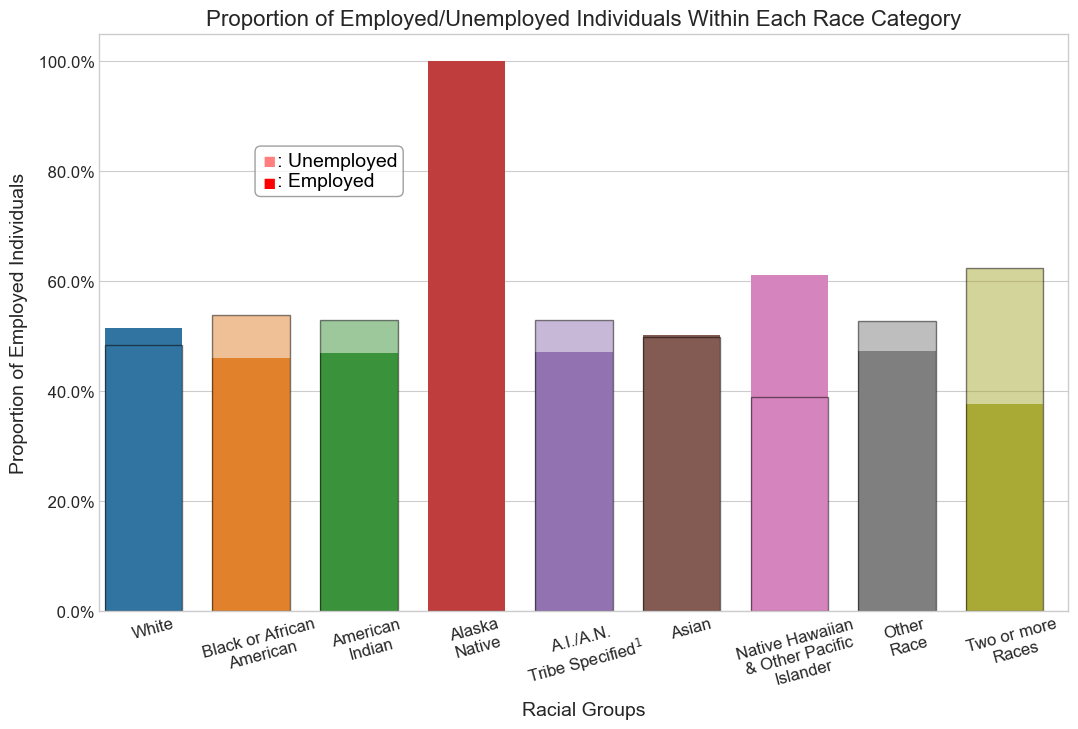

In [24]:
# Plotting proportion of employed individuals across each race
fig, ax = plt.subplots(1, 1, figsize = (12.5, 7.5))
sns.barplot(race_prop_emp, x = "race", y = "emp_status", hue = "race", palette = sns.color_palette()[:-1], width = 0.9, ax = ax, legend = False)
sns.barplot(race_prop_emp, x = "race", y = "u_emp", hue = "race", palette = sns.color_palette()[:-1], width = 0.9, ax = ax, legend = False, alpha = 0.5, edgecolor = "black")

# Adding space between bars
for patch in ax.patches:
    patch.set_width(patch.get_width() * 0.8)
ax.set_title("Proportion of Employed/Unemployed Individuals Within Each Race Category", fontsize = 16)
ax.set_xticks(range(9))
ax.set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], fontsize = 12, rotation = 15)
ax.set_xlabel("Racial Groups", fontsize = 14)
ax.set_ylabel("Proportion of Employed Individuals", fontsize = 14)
ax.set_yticks([(0.2 * i) for i in range(6)])
ax.set_yticklabels([f"{(0.2 * i) * 100: .1f}%" for i in range(6)], fontsize = 12)
ax.text(1, 0.8, f"   : Unemployed\n   : Employed", ha = "left", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax.text(1.075, 0.82, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red", alpha = 0.5)
ax.text(1.075, 0.78, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red")

plt.show()

*Code above plots the proportions calculated above*

**Figure 2**

Of the individuals across each racial group:

-   About $51.5\%$ of white individuals are employed
-   About $46\%$ of black or African American individuals are employed
-   About $47\%$ of  American Indian individuals are employed
-   Seemingly all ($100\%$) of Alaska Native individuals are employed
-   $^1$ About $47\%$ of individuals identifying as American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, or not specified and of no other races are employed
-   About $50\%$ of Asian individuals are employed
-   About $61\%$ of Native Hawaiian and Other Pacific Islander individuals are employed
-   About $47.3\%$ of individuals identifying as some other race are employed
-   About $38\%$ of individuals identifying as two or more races are employed

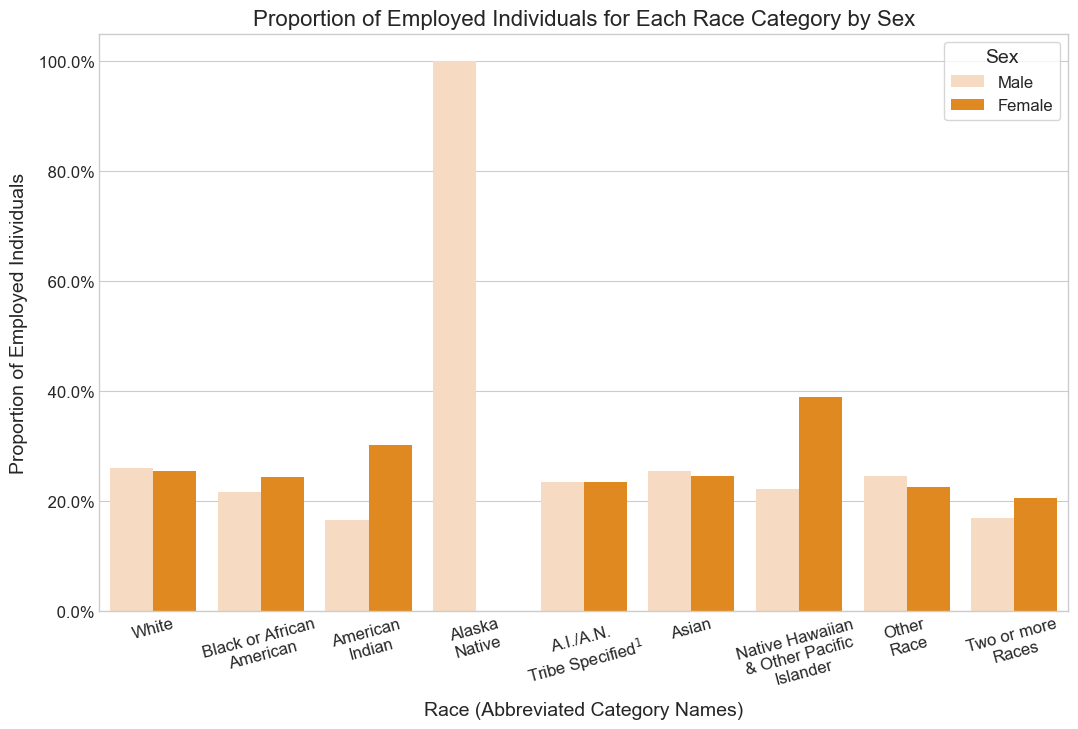

16.67


In [25]:
# Examining the intersection of race and gender as it relates to employment
# emp = train[train["emp_status"] == 1]

# Array to store proportions of employed male and female individuals for each race
ixn_data = []
for race in train["race"].unique():
    curr_race = train[train["race"] == race]
    m_emp_prop = curr_race[(curr_race["SEX"] == 1.0) & (curr_race["emp_status"] == 1)].shape[0] / curr_race.shape[0]
    f_emp_prop = curr_race[(curr_race["SEX"] == 2.0) & (curr_race["emp_status"] == 1)].shape[0] / curr_race.shape[0]
    ixn_data.append({"Race": race, "Sex": "Male", "Emp_prop": m_emp_prop})
    ixn_data.append({"Race": race, "Sex": "Female", "Emp_prop": f_emp_prop})
ixn_data = pd.DataFrame(ixn_data)

# Barplot to display the intersection of race and gender in employment status
fig, ax = plt.subplots(1, 1, figsize = (12.5, 7.5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.barplot(ixn_data, x = "Race", y = "Emp_prop", hue = "Sex", palette = ["#FFDAB9", "darkorange"], ax = ax)
ax.set_title("Proportion of Employed Individuals for Each Race Category by Sex", fontsize = 16)
ax.set_ylabel("Proportion of Employed Individuals", fontsize = 14)
ax.set_xlabel("Race (Abbreviated Category Names)", fontsize = 14)
ax.set_xticks(range(0, 9))
ax.set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], 
                   fontsize = 12, rotation = 15)
ax.set_yticks([(0.2 * i) for i in range(6)])
ax.set_yticklabels([f"{(0.2 * i) * 100: .1f}%" for i in range(6)], fontsize = 12)
ax.legend(frameon = True, fontsize = 12, title = "Sex", title_fontsize = 14)

plt.show()

emp_m = train[(train["race"] == 7.0) & (train["emp_status"] == 1) & (train["SEX"] == 1.0)].shape[0] / train[train["race"] == 7.0].shape[0]
emp_w = train[(train["race"] == 7.0) & (train["emp_status"] == 1) & (train["SEX"] == 2.0)].shape[0] / train[train["race"] == 7.0].shape[0]
print(round(np.abs(emp_m - emp_w) * 100, 2))

*Code above calculates and plots the proportions of employment (of all employed individuals) for each race by sex.*

*$^1$"A.I./A.N.\nTribe Specified": Individuals who are American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, or not specified and of no other races.*

**Figure 3**

The figure above displays the possible intersectionality between race and sex among employed individuals.  For six of the nine race categories (all but American Indian, Alaska Native, and Native Hawaiian & Other Pacific Islander) found in this data set, there does not appear to be a significant difference ($<5\%$) in employment rates between males and females.  However, for the remaining racial groups, there does appear to be a noteworthy difference ($>10\%$) in employment rates between males and females.  Therefore, based on this figure, there generally does not appear to be a significant intersectional effect of race and sex on employment rates across all racial groups, but for some groups, an intersectional effect may be present.  Please note that this finding does not dismiss the presence of intersectional biases and systemic injustices that may impact certain individuals from this data set.  The existence of such intersectionality may very well be present in the data and but just not captured by this figure.  Observing the intersectionality of race and gender relating to employment may be more clearly observed through other statistical processes.

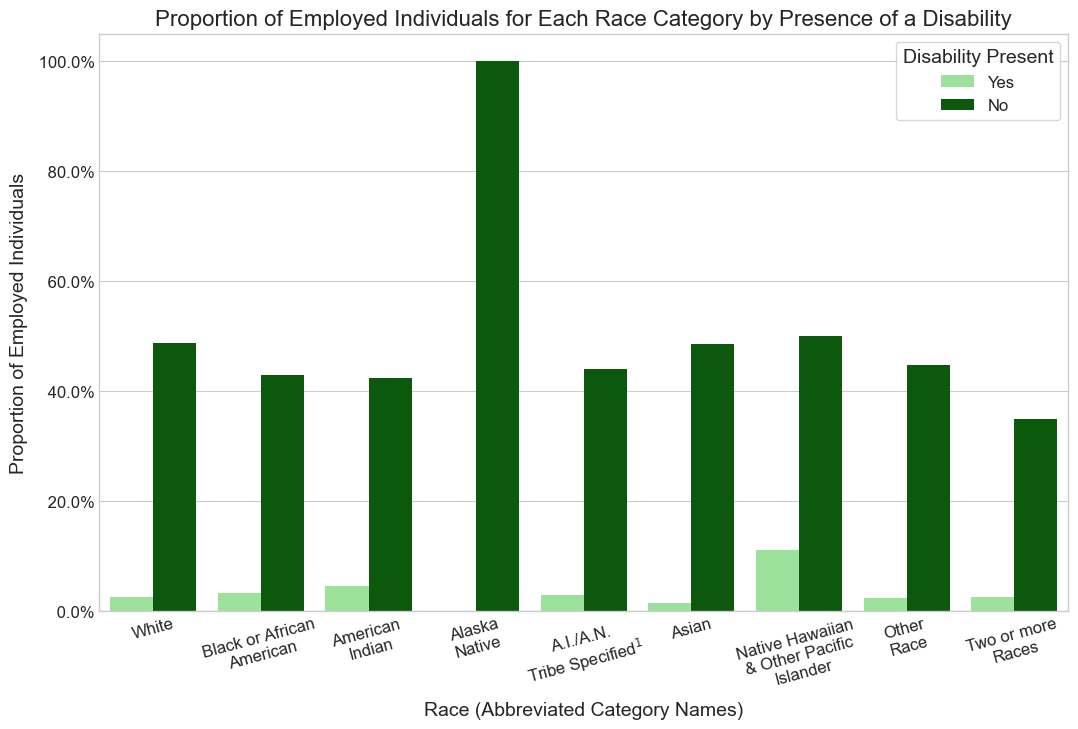

In [26]:
# Examining the intersection of race and disability as it relates to employment
## Array to store proportions of employed visually impaired and non-visually impaired individuals for each race
ixn_data = []
for race in train["race"].unique():
    curr_race = train[train["race"] == race]
    d_emp_prop = curr_race[(curr_race["DIS"] == 1.0) & (curr_race["emp_status"] == 1)].shape[0] / curr_race.shape[0]
    nd_emp_prop = curr_race[(curr_race["DIS"] == 2.0) & (curr_race["emp_status"] == 1)].shape[0] / curr_race.shape[0]
    ixn_data.append({"Race": race, "Disability Present": "Yes", "Emp_prop": d_emp_prop})
    ixn_data.append({"Race": race, "Disability Present": "No", "Emp_prop": nd_emp_prop})
ixn_data = pd.DataFrame(ixn_data)
ixn_data.head()

# Barplot to display the intersection of race and gender in employment status
fig, ax = plt.subplots(1, 1, figsize = (12.5, 7.5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.barplot(ixn_data, x = "Race", y = "Emp_prop", hue = "Disability Present", palette = ["lightgreen", "darkgreen"], ax = ax)
# ax.set_yscale("log", base = 10)
ax.set_title("Proportion of Employed Individuals for Each Race Category by Presence of a Disability", fontsize = 16)
ax.set_ylabel("Proportion of Employed Individuals", fontsize = 14)
ax.set_xlabel("Race (Abbreviated Category Names)", fontsize = 14)
ax.set_xticks(range(0, 9))
ax.set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], 
                   fontsize = 12, rotation = 15)
ax.set_yticks([(0.2 * i) for i in range(6)])
ax.set_yticklabels([f"{(0.2 * i) * 100: .1f}%" for i in range(6)], fontsize = 12)
ax.legend(frameon = True, fontsize = 12, title = "Disability Present", title_fontsize = 14)

plt.show()

*Code above calculates and plots the proportions of employment (of all employed individuals) for each race by disability presence.*

*$^1$"A.I./A.N.\nTribe Specified": Individuals who are American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, or not specified and of no other races.*

**Figure 4**

The figure above displays the possible intersectionality between race and disability among employed individuals.  Unlike the apparent general lack of intersectionality between race and sex, for all of the nine race categories found in this data set, there appears to be a significant difference in employment rates between individuals with and without disabilities present.  That is, it seems that the lowest overall proportions of employed individuals tend to be found at the combination of low-employment racial groups and when a disability is present.  Thus, based on this figure, I believe that it is reasonable to identify an observable intersectional effect of race and disability on employment rates.

### Constructing and Fitting the Model

In [27]:
# Constructing and fitting the model
model = make_pipeline(StandardScaler(), DecisionTreeClassifier())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [28]:
# Refining the model
## Identifying the optimal max_depth value - Model Complexity parameter for DecisionTreeCLassifier model - though iterative process
# #Updated variables
best_max_depth = None
best_avg_score = 0
for md in np.random.randint(1, 101, size = 10):
    model.set_params(decisiontreeclassifier__max_depth = md)
    avg_score = cross_val_score(model, X_train, y_train, cv = 5).mean()
    if avg_score > best_avg_score:
        best_avg_score = avg_score
        best_max_depth = md

# Fitting the model with the optimal max_depth value
dtc_refined = model.set_params(decisiontreeclassifier__max_depth = best_max_depth)
dtc_refined.fit(X_train, y_train)
gen_score = dtc_refined.score(X_train, y_train)
print(f"Refined Model Overall Accuracy: {gen_score * 100: .3f}%")

Refined Model Overall Accuracy:  82.062%


*Code above uses the `make_pipeline` method from the `sklearn` package, the training data is first standardized and then used to fit a `DecisionTreeClassifier` model (also from `sklearn`).  The `max_depth` parameter for the model is tuned iteratively with corss-validation to set the tree depth that maximizes overall accuracy while mitigating model over-fitting.*

To refine the model, an iterative process tuning the model complexity (using the `max_depth` parameter) with cross-validation is conducted.  This process aims at model maximizing trining accuracy while reducing the presence of model over-fitting.  Following this tuning procedure, the model has an overall accuracy of approximately $83.6\%$ -- as an initial metric, this indicates a considerable accurate model.

### General Accuracy and Error Rates

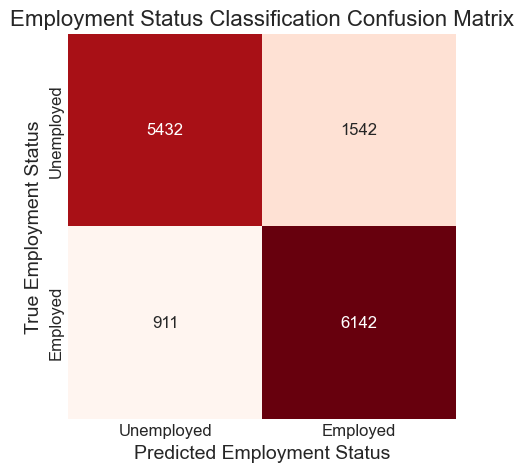

There were 5432 unemployed individuals that were predicted to be unemployed.
There were 1542 unemployed individuals that were predicted to be employed.
There were 911 employed individuals that were predicted to be unemployed.
There were 6142 unemployed individuals that were predicted to be employed.
Overall Testing Accuracy:  82.512%
General False Negative Rate:  12.916%
General True Negative Rate:  77.889%
General False Positive Rate:  22.111%
General True Positive Rate:  87.084%
General Positive Predictive Value:  79.932%
General Negative Predictive Value:  85.638%


In [29]:
# Calculating various accuracy metrics
## Overall Test data accuracy
acc_t = dtc_refined.score(X_test, y_test)
y_preds_t = dtc_refined.predict(X_test).astype(int)
acc_t = (y_preds_t == y_test).mean()

# Confusion matrix for refined model
C = confusion_matrix(y_test, y_preds_t)
emp_status = ["Unemployed", "Employed"]

# Creating a heatmap for better confusion matrix visualization
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.heatmap(C, annot = True, annot_kws = {"size": 12}, fmt = "d", cmap = "Reds", cbar = False, ax = ax)

# Plot styling
ax.set_xlabel("Predicted Employment Status", fontsize = 14)
ax.set_ylabel("True Employment Status", fontsize = 14)
ax.set_xticklabels(emp_status, fontsize = 12)
ax.set_yticklabels(emp_status, fontsize = 12)
ax.set_title("Employment Status Classification Confusion Matrix", fontsize = 16)

plt.show()

# Printing confusion matrix results
print(f"There were {C[0, 0]} unemployed individuals that were predicted to be unemployed.")
print(f"There were {C[0, 1]} unemployed individuals that were predicted to be employed.")
print(f"There were {C[1, 0]} employed individuals that were predicted to be unemployed.")
print(f"There were {C[1, 1]} unemployed individuals that were predicted to be employed.")

# Calculating various accuracies and error rates
g_fnr = C[1, 0] / (C[1, 0] + C[1, 1])
g_tnr = C[0, 0] / (C[0, 0] + C[0, 1])
g_fpr = 1 - g_tnr
g_tpr = 1 - g_fnr
g_ppv = C[1, 1] / (C[1, 1] + C[0, 1])
g_npv = C[0, 0] / (C[0, 0] + C[1, 0])

print(f"Overall Testing Accuracy: {acc_t * 100: .3f}%")
print(f"General False Negative Rate: {g_fnr * 100: .3f}%")
print(f"General True Negative Rate: {g_tnr * 100: .3f}%")
print(f"General False Positive Rate: {g_fpr * 100: .3f}%")
print(f"General True Positive Rate: {g_tpr * 100: .3f}%")
print(f"General Positive Predictive Value: {g_ppv * 100: .3f}%")
print(f"General Negative Predictive Value: {g_npv * 100: .3f}%")

*Code above constructs the general confusion matrix for the refined model and calculates the typical accuracy/error rates: FPR, FNR, TPR, TNR, PPV, and NPV*

**Figure 5**

Some key overall accuracy and error rates of the refined model are:

-   Overall Test Accuracy: About $83\%$
-   FNR: About $13\%$ of truly employed individuals were misclassified as unemployed.
-   TNR: About $79\%$ of truly unemployed individuals were correctly classified as unemployed.
-   FPR: About $21\%$ of truly unemployed individuals were misclassified as employed.
-   TPR: About $87\%$ of truly employed individuals were correctly classified as employed
-   PPV: About $81\%$ of "employed" model predictions are correct while only about $20\%$ are incorrect.
-   NPV: About $86\%$ of "unemployed" model predictions are correct while only about $14\%$ are incorrect.

The general accuracy and error rates outlined above indicate that the refined model is approximately similarly but not equally accurate in predicting that truly unemployed individuals are unemployed versus predicting that truly employed individuals are employed.  Additionally, the refined misclassifies truly unemployed individuals and truly employed individuals at similar but notably unequal rates.  The refined model yields a PPV and NPV that are close in value (with a difference of $<7\%$).  This suggests that, for any given individual, the refined model is generally similarly good at predicting if this individual is employed as it is at predicting if this individual is unemployed.

While the overall accuracy of the refined model is appears decently high ($83\%$), it is crucial to investigate the same accuracy rates across different groups of observations found in the data.  In this context, the prediction task is to identify if an individual is employed or not.  In the data, the race of each individual is provided, and not only is race undoubtedly related to employment in the US but race is also a factor by which systemic biases and systematic discrimination occurs in the American workforce.  Although the model was not trained using this variable (race), there is no guarantee that the model does not rely on variables highly related to race or that could stand as proxies for race.  Thus, it is critically important to examine if the model perpetuates systemic biases and past injustices effecting certain individuals differently on the bases of racial identity. 

## Auditing the Model for Racial Bias
### Examining Model Accuracy and Error Rates Across Each Racial Category

In [30]:
# Adding a column for indicating correct predictions
test = pd.DataFrame(X_test, columns = vars1)
test["emp_status"] = y_test
test["pred"] = y_preds_t
test["correct_pred"] = (y_preds_t == y_test).astype(int)

# Recoding race variable for easier visualization
race_recode = {
    1.0: "White",
    2.0: "Black or African American",
    3.0: "American Indian",
    4.0: "Alaska Native",
    5.0: f"A.I./A.N. Tribe Specified\u00B9",
    6.0: "Asian",
    7.0: " Native Hawaiian and Other Pacific Islander",
    8.0: "Some Other Race",
    9.0: " Two or More Races"
}
test["race"] = group_test
test["Racial Group (Abbreviated Categories)"] = test["race"].map(race_recode)

# Helper functions to calculate various accuracy and error rate metrics
def acc(x):
    if (x.shape[0] == 0):
        return "NA"
    
    return str(round(x["correct_pred"].mean() * 100, 1)) + " %"

def prop(x):
    return str(round((x.shape[0] / train.shape[0]) * 100, 1)) + " %"

def fpr(x):
    fp = ((x["pred"] == 1) & (x["emp_status"] == 0)).sum()
    tn = ((x["pred"] == 0) & (x["emp_status"] == 0)).sum()
    if ((fp + tn) == 0):
        return "NA"
    fpr = fp / (fp + tn)
    
    return str(round(fpr * 100, 1)) + " %"

def fnr(x):
    fn = ((x["pred"] == 0) & (x["emp_status"] == 1)).sum()
    tp = ((x["pred"] == 1) & (x["emp_status"] == 1)).sum()
    if ((fn + tp) == 0):
        return "NA"
    fnr = fn / (fn + tp)

    return str(round(fnr * 100, 1)) + " %"

def tpr(x):
    fn = ((x["pred"] == 0) & (x["emp_status"] == 1)).sum()
    tp = ((x["pred"] == 1) & (x["emp_status"] == 1)).sum()
    if ((fn + tp) == 0):
        return "NA"
    tpr = tp / (fn + tp)

    return str(round(tpr * 100, 1)) + " %"

def tnr(x):
    fp = ((x["pred"] == 1) & (x["emp_status"] == 0)).sum()
    tn = ((x["pred"] == 0) & (x["emp_status"] == 0)).sum()
    if ((fp + tn) == 0):
        return "NA"
    tnr = tn / (fp + tn)
    
    return str(round(tnr * 100, 1)) + " %"

def ppv(x):
    tp = ((x["pred"] == 1) & (x["emp_status"] == 1)).sum()
    fp = ((x["pred"] == 1) & (x["emp_status"] == 0)).sum()
    if ((tp + fp) == 0):
        return "NA"
    ppv = tp / (tp + fp)
    
    return str(round(ppv * 100, 1)) + " %"

def npv(x):
    tn = ((x["pred"] == 0) & (x["emp_status"] == 0)).sum()
    fn = ((x["pred"] == 0) & (x["emp_status"] == 1)).sum()
    if ((tn + fn) == 0):
        return "NA"
    npv = tn / (tn + fn)

    return str(round(npv * 100, 1)) + " %"

# Initializing data frame to visualize model accuracy and error rates for each race
race_acc = pd.DataFrame(index = range(1, 10), columns = ["Racial Group (Abbr. Cats.)", "Model Accuracy", "Proportion to Tot. (Aprx.)", "FPR", "FNR", "TPR", "TNR", "PPV", "NPV"])

# Subsetting training data into each race category
r1 = test[test["race"] == 1.0]
r2 = test[test["race"] == 2.0]
r3 = test[test["race"] == 3.0]
r4 = test[test["race"] == 4.0]
r5 = test[test["race"] == 5.0]
r6 = test[test["race"] == 6.0]
r7 = test[test["race"] == 7.0]
r8 = test[test["race"] == 8.0]
r9 = test[test["race"] == 9.0]

# Populating the accuracy/error rates table
race_acc.loc[1] = [race_recode.get(1.0), acc(r1), prop(r1), fpr(r1), fnr(r1), tpr(r1), tnr(r1), ppv(r1), npv(r1)]
race_acc.loc[3] = [race_recode.get(2.0), acc(r2), prop(r2), fpr(r2), fnr(r2), tpr(r2), tnr(r2), ppv(r2), npv(r2)]
race_acc.loc[2] = [race_recode.get(3.0), acc(r3), prop(r3), fpr(r3), fnr(r3), tpr(r3), tnr(r3), ppv(r3), npv(r3)]
race_acc.loc[4] = [race_recode.get(4.0), acc(r4), prop(r4), fpr(r4), fnr(r4), tpr(r4), tnr(r4), ppv(r4), npv(r4)]
race_acc.loc[5] = [race_recode.get(5.0), acc(r5), prop(r5), fpr(r5), fnr(r5), tpr(r5), tnr(r5), ppv(r5), npv(r5)]
race_acc.loc[6] = [race_recode.get(6.0), acc(r6), prop(r6), fpr(r6), fnr(r6), tpr(r6), tnr(r6), ppv(r6), npv(r6)]
race_acc.loc[7] = [race_recode.get(7.0), acc(r7), prop(r7), fpr(r7), fnr(r7), tpr(r7), tnr(r7), ppv(r7), npv(r7)]
race_acc.loc[8] = [race_recode.get(8.0), acc(r8), prop(r8), fpr(r8), fnr(r8), tpr(r8), tnr(r8), ppv(r8), npv(r8)]
race_acc.loc[9] = [race_recode.get(9.0), acc(r9), prop(r9), fpr(r9), fnr(r9), tpr(r9), tnr(r9), ppv(r9), npv(r9)]
race_acc

,Racial Group (Abbr. Cats.),Model Accuracy,Proportion to Tot. (Aprx.),FPR,FNR,TPR,TNR,PPV,NPV
1,White,82.3 %,20.2 %,21.8 %,13.8 %,86.2 %,78.2 %,80.4 %,84.5 %
2,American Indian,88.2 %,0.0 %,11.1 %,12.5 %,87.5 %,88.9 %,87.5 %,88.9 %
3,Black or African American,85.1 %,1.5 %,19.7 %,9.5 %,90.5 %,80.3 %,80.2 %,90.5 %
4,Alaska Native,NA,0.0 %,NA,NA,NA,NA,NA,NA
5,A.I./A.N. Tribe Specified¹,80.0 %,0.0 %,0.0 %,33.3 %,66.7 %,100.0 %,100.0 %,66.7 %
6,Asian,81.4 %,1.7 %,30.5 %,7.3 %,92.7 %,69.5 %,76.3 %,90.0 %
7,Native Hawaiian and Other Pacific Islander,88.9 %,0.0 %,33.3 %,0.0 %,100.0 %,66.7 %,85.7 %,100.0 %
8,Some Other Race,85.1 %,0.8 %,22.8 %,5.9 %,94.1 %,77.2 %,78.3 %,93.7 %
9,Two or More Races,83.7 %,0.7 %,16.9 %,15.5 %,84.5 %,83.1 %,77.6 %,88.5 %


*Code above subsets the training data into each race category and creates a table displaying the model's accuracy and error rates in employment/unemployment predictions for each racial group.*

*$^1$"A.I./A.N.\nTribe Specified": Individuals who are American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, or not specified and of no other races.*

**Table 1**

The table above depicts the refined model's accuracy and error rates for employment prediction of individuals across each racial group in the training data.  The general accuracies for each racial group are all largely similar -- with values ranging from around $80\%$ to $89\%$ accuracy.  

$$FPR = \frac{FP}{FP + TN}$$
$$FNR = \frac{FN}{FN + TP}$$


The FPR and FNR for each race are slightly less equal across all racial groups (FPR range from roughly $0\%$ to $33\%$ and FNR range also from $0\%$ to $33\%$), but these error rates do not differ dramatically.  

$$TPR = \frac{TP}{TP + FN}$$
$$TNR = \frac{TN}{TN + FP}$$

A similar trend is generally observable for TPR across each racial group (majority TPR range from about $83\%$ to $100\%$) - with the exception of the "American Indian and Alaska Native tribes specified" group with a notably lower TPR: $67\%$).  As for TNR, there is a larger spread in values across all racial groups with a general TNR range of $67\%$ to $100\%$.  

$$PPV = \frac{TP}{TP + FP}$$
$$NPV = \frac{TN}{TN + FN}$$

Further, the PPV and NPV for each racial group are primarily similar and display a smaller spread of values -- with PPV metrics ranging from approximately $77\%$ to $100\%$ and NPV values ranging from approximately $67\%$ to $100\%$.

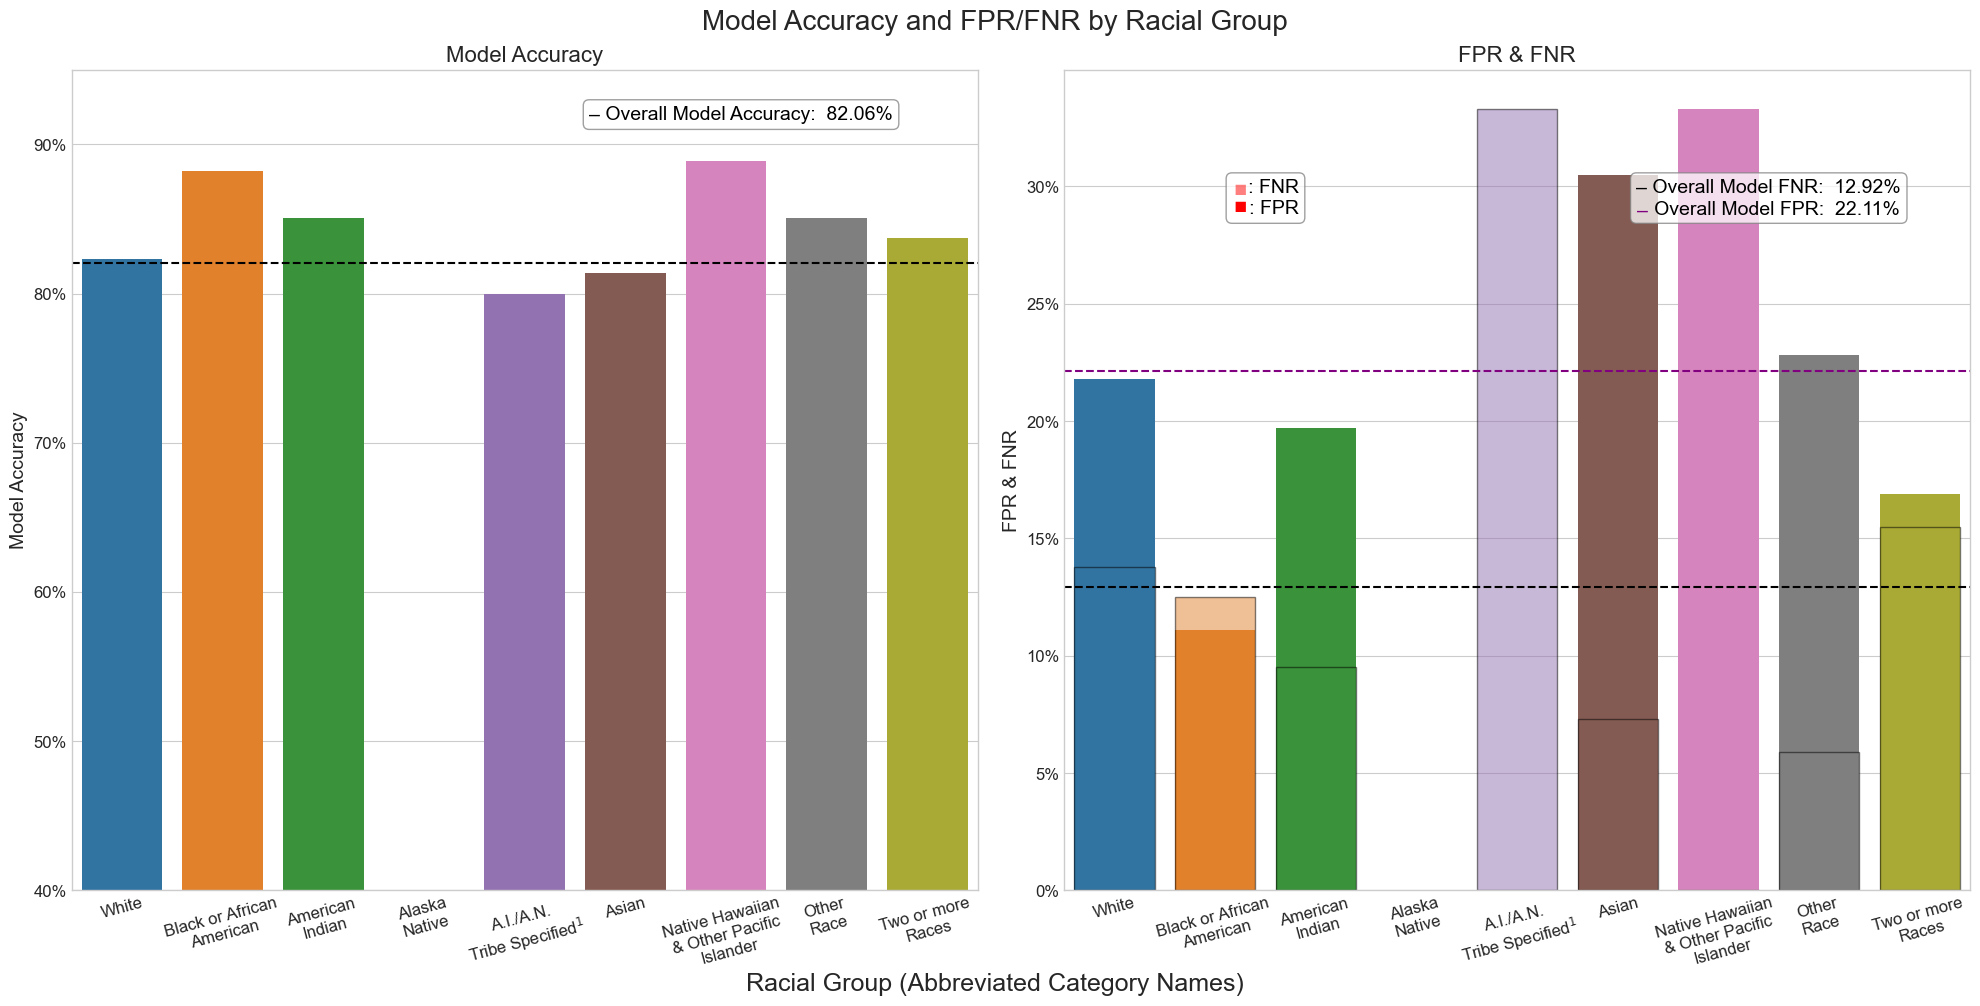

In [31]:
# Changing column types for easier visualization
## Saving a data frame for late use
erb = race_acc.copy()
for col in race_acc.columns[1:]:
    if (race_acc[col].dtype == "object"):
        race_acc[col] = pd.to_numeric(race_acc[col].str.replace("%", "").replace("NA", np.nan))

# Plotting the information described in the table above for easier visualization
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
plt.style.use("seaborn-v0_8-whitegrid")

# Accuracy by Race
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "Model Accuracy", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], ax = ax[0])
ax[0].axhline(gen_score * 100, color = "black", linestyle = "--")
ax[0].set_ylim(40, 95)
ax[0].set_title("Model Accuracy", fontsize = 16)
ax[0].set_xlabel("")
ax[0].set_ylabel("Model Accuracy", fontsize = 14)
ax[0].set_xticks(range(9))
ax[0].set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], fontsize = 12, rotation = 15)
ax[0].set_yticks([(10 * i) for i in range(4, 10)])
ax[0].set_yticklabels([f"{10 * i}%" for i in range(4, 10)], fontsize = 12)
ax[0].text(6.15, 92, f"\u2013 Overall Model Accuracy: {gen_score * 100: .2f}%", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))

# FPR & FNR by Race
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "FPR", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], ax = ax[1])
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "FNR", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], alpha = 0.5, ax = ax[1], edgecolor = "black")
ax[1].axhline(g_fpr * 100, color = "purple", linestyle = "--")
ax[1].axhline(g_fnr * 100, color = "black", linestyle = "--")
ax[1].set_title("FPR & FNR", fontsize = 16)
ax[1].set_xlabel("")
ax[1].set_ylabel("FPR & FNR", fontsize = 14)
ax[1].set_xticks(range(9))
ax[1].set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], fontsize = 12, rotation = 15)
ax[1].set_yticks([i for i in range(0, 35, 5)])
ax[1].set_yticklabels([f"{i}%" for i in range(0, 35, 5)], fontsize = 12)
ax[1].text(6.5, 29.5, f"\u2013 Overall Model FNR: {g_fnr * 100: .2f}%\n", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[1].text(6.5, 29, f"   Overall Model FPR: {g_fpr * 100: .2f}%", ha = "center", va = "center", fontsize = 14, color = "black")
ax[1].text(5.25, 29, "\u2013", ha = "center", va = "center", fontsize = 14, color = "purple")
ax[1].text(1.5, 29.5, f"   : FNR\n   : FPR", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[1].text(1.25, 29.9, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red", alpha = 0.5)
ax[1].text(1.25, 29.2, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red")

fig.suptitle("Model Accuracy and FPR/FNR by Racial Group", fontsize = 20)
fig.text(0.5, 0.005, "Racial Group (Abbreviated Category Names)", ha = "center", va = "center", fontsize = 18)
plt.tight_layout()

*Code above uses the data frame constructed in the previous chunk to plot the overall model accuracy and FPR/FNR by racial group*

**Figure 6**

The plots above provide a visual accompaniment to the information displayed in **Table 1**.  As shown in overall accuracy plot (left), the model's accuracy for the majority of racial groups is lower than the general accuracy.  The largest disparity in general accuracy to the accuracy for a specific racial group is found for individuals identifying as Native Hawaiian & Other Pacific Islander.  Regarding FPR anf FNR, the model's error rates across the racial groups appear to differ considerably both from one another and also from the general FPR and FNR.

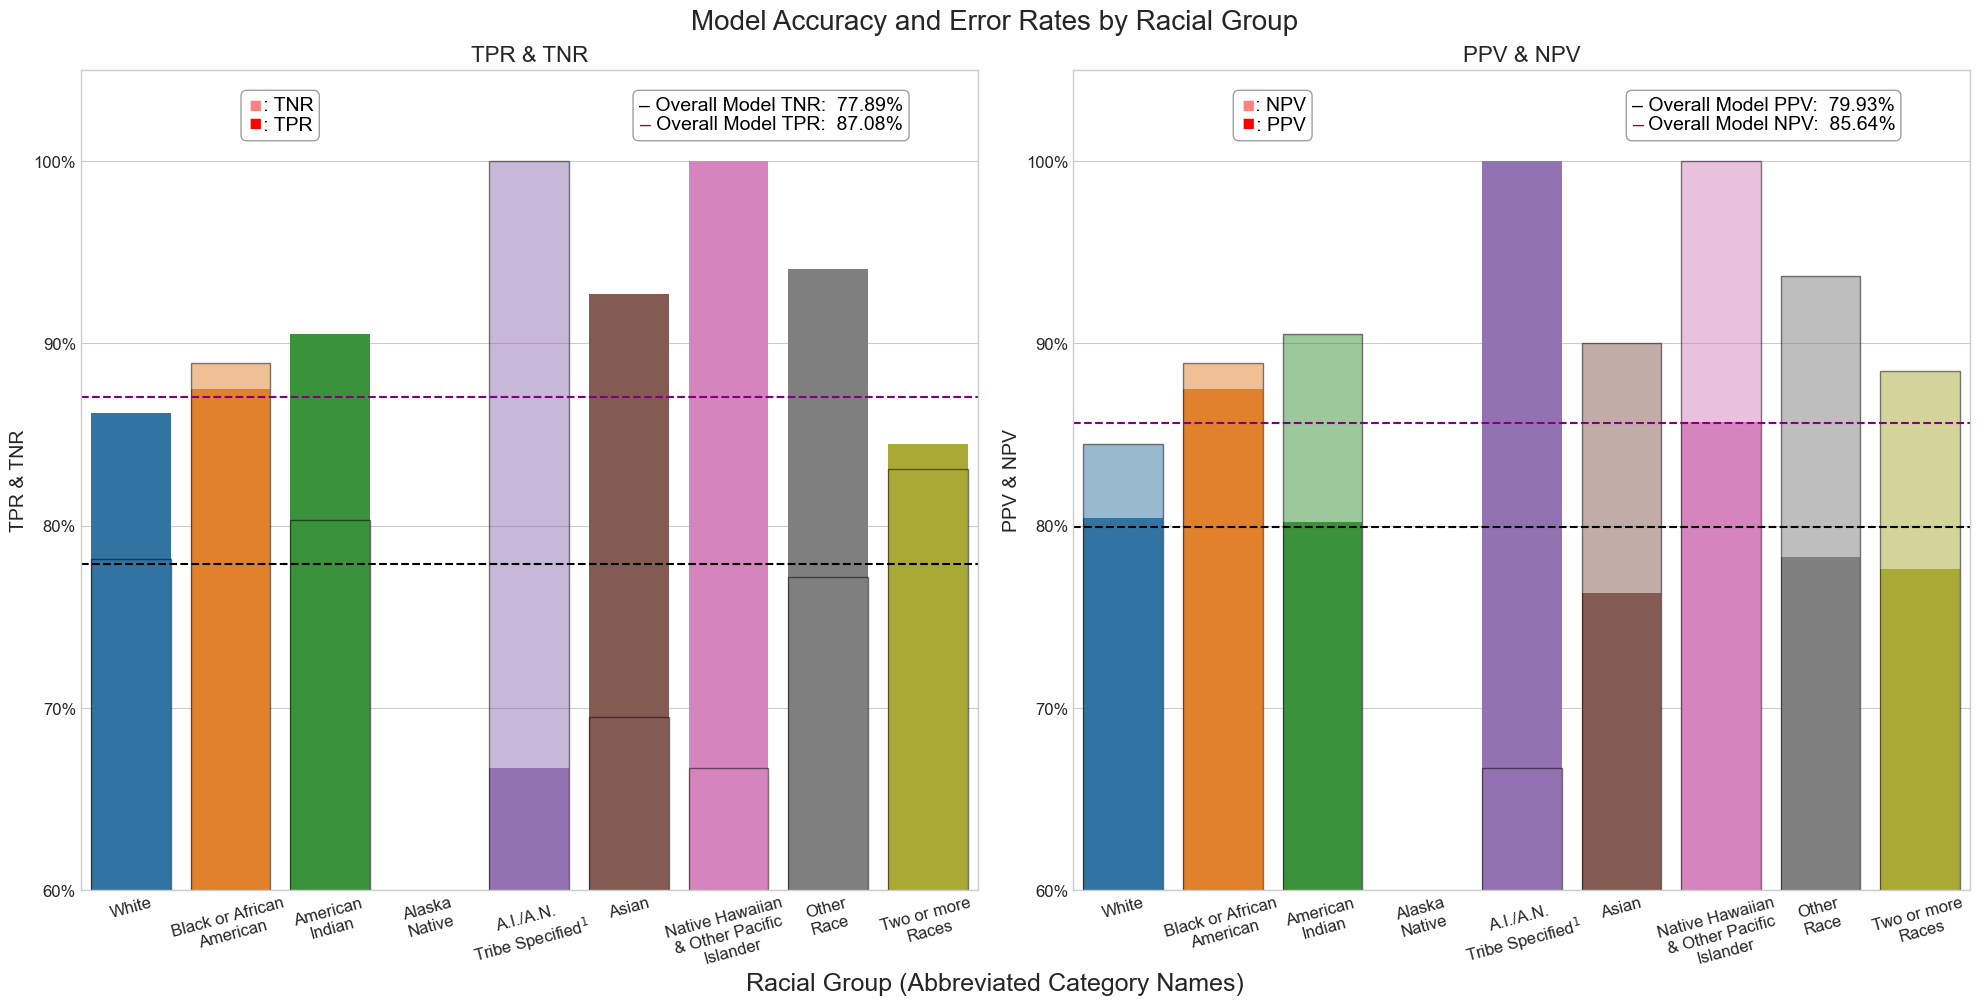

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
plt.style.use("seaborn-v0_8-whitegrid")

# TPR & TNR by Race
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "TPR", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], ax = ax[0])
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "TNR", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], alpha = 0.5, ax = ax[0], edgecolor = "black")
ax[0].axhline(g_tpr * 100, color = "purple", linestyle = "--")
ax[0].axhline(g_tnr * 100, color = "black", linestyle = "--")
ax[0].set_ylim(60, 105)
ax[0].set_title("TPR & TNR", fontsize = 16)
ax[0].set_xlabel("")
ax[0].set_ylabel("TPR & TNR", fontsize = 14)
ax[0].set_xticks(range(9))
ax[0].set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], fontsize = 12, rotation = 15)
ax[0].set_yticks(range(0, 110, 10)[6:])
ax[0].set_yticklabels([f"{i}%" for i in (range(0, 110, 10)[6:])], fontsize = 12)
ax[0].text(6.427, 102.5, f"\u2013 Overall Model TNR: {g_tnr * 100: .2f}%\n", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0].text(6.427, 102, f"   Overall Model TPR: {g_tpr * 100: .2f}%", ha = "center", va = "center", fontsize = 14, color = "black")
ax[0].text(5.17, 102, "\u2013", ha = "center", va = "center", fontsize = 14, color = "purple")
ax[0].text(1.5, 102.5, f"   : TNR\n   : TPR", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0].text(1.25, 103.1, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red", alpha = 0.5)
ax[0].text(1.25, 102.1, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red")

# PPV & NPV by Race
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "PPV", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], ax = ax[1])
sns.barplot(race_acc, x = "Racial Group (Abbr. Cats.)", y = "NPV", hue = "Racial Group (Abbr. Cats.)", palette = sns.color_palette()[:-1], alpha = 0.5, ax = ax[1], edgecolor = "black")
ax[1].axhline(g_npv * 100, color = "purple", linestyle = "--")
ax[1].axhline(g_ppv * 100, color = "black", linestyle = "--")
ax[1].set_ylim(60, 105)
ax[1].set_title("PPV & NPV", fontsize = 16)
ax[1].set_xlabel("")
ax[1].set_ylabel("PPV & NPV", fontsize = 14)
ax[1].set_xticks(range(9))
ax[1].set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "Alaska\nNative", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], fontsize = 12, rotation = 15)
ax[1].set_yticks(range(0, 110, 10)[6:])
ax[1].set_yticklabels([f"{i}%" for i in (range(0, 110, 10)[6:])], fontsize = 12)
ax[1].text(6.427, 102.5, f"\u2013 Overall Model PPV: {g_ppv * 100: .2f}%\n", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[1].text(6.427, 102, f"   Overall Model NPV: {g_npv * 100: .2f}%", ha = "center", va = "center", fontsize = 14, color = "black")
ax[1].text(5.17, 102, "\u2013", ha = "center", va = "center", fontsize = 14, color = "purple")
ax[1].text(1.5, 102.5, f"   : NPV\n   : PPV", ha = "center", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[1].text(1.25, 103.1, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red", alpha = 0.5)
ax[1].text(1.25, 102.1, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red")

fig.suptitle("Model Accuracy and Error Rates by Racial Group", fontsize = 20)
fig.text(0.5, 0.005, "Racial Group (Abbreviated Category Names)", ha = "center", va = "center", fontsize = 18)
plt.tight_layout()

*Code above uses the data frame constructed in the previous chunk to plot the and TPR/TNR and PPV/NPV by racial group*

**Figure 7**

The plots above provide additional visual accompaniment for the accuracy rates and predictive values displayed in **Table 1**.  As shown in the plot of TPR/TNR for each racial group, the TPR and TNR tend to deviate notably both from one another and from the model's general TPR/TNR.  For some racial groups though, such as white individuals in the data, the TPR and TNR are very close to the general TPR/TNR.  As shown on the right, the the PPV and NPV metrics for each racial group are generally not majorly far from the overall PPV and NPV.  However, note that this trend does not extend to all racial groups, such as individuals in the "A.I./A.N. Tribe Specified" or Native Hawaiian & Other Pacific Islander groups, who have a notably lower NPV values than the general NPV.

Based on the information depicted in the **Table 1** and the plots from **Figure 7** and **Figure 8**, it is clear that the model's accuracy and error rates are not entirely consistent across all racial groups.  This inconsistency is particularly concerning for individuals identifying as A.I./A.N. Tribe Specified $^1$, Asian, or Native Hawaiian & Other Pacific Islander.  That is, for individuals associating with these racial groups, it appears that the model is not as good at making accurate predictions of employment status as it is for predicting the employment status of other racial groups.  This analysis suggests that the model may be perpetuating (through the cost of its misclassifications) systemic biases and past injustices that effect certain individuals differently on the bases of racial identity.

### Bias Measures

#### Calibration:

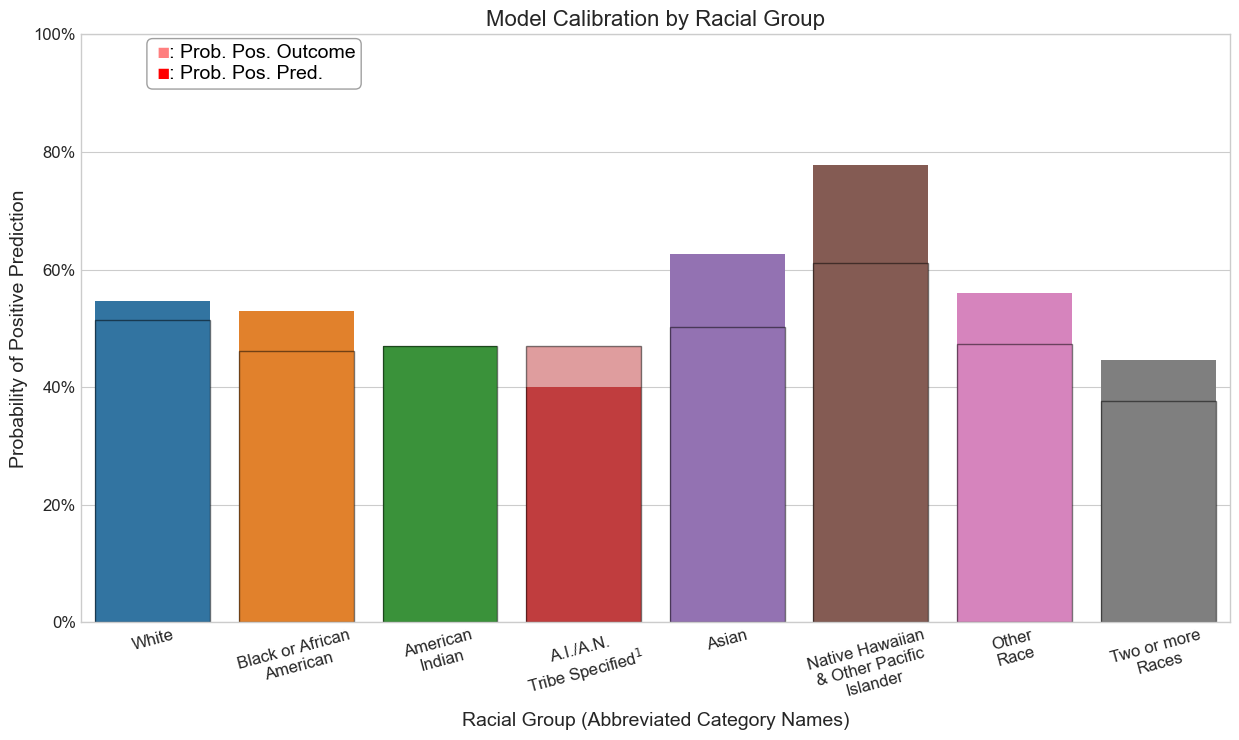

In [33]:
# Examining the calibration of the model
## Calculating the probability that a prediction is positive for each racial group
calibration = test.groupby("race").aggregate({"pred": "mean"})
calibration["pred"] = calibration["pred"] * 100
calibration["pred_prob_diff"] = np.abs(calibration["pred"] - ((test["pred"]).mean() * 100))
calibration["emp_status_rate"] = train.groupby("race").aggregate({"emp_status": "mean"}) * 100

calibration

# # Plotting these probabilities for each racial group
fig, ax = plt.subplots(1, 1, figsize = (12.5, 7.5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.barplot(calibration, x = "race", y = "pred", hue = "race", palette = sns.color_palette()[:-2], ax = ax, legend = False)
sns.barplot(calibration, x = "race", y = "emp_status_rate", hue = "race", palette = sns.color_palette()[:-2], ax = ax, legend = False, alpha = 0.5, edgecolor = "black")
ax.set_title("Model Calibration by Racial Group", fontsize = 16)
ax.set_xlabel("Racial Group (Abbreviated Category Names)", fontsize = 14)
ax.set_xticks(range(8))
ax.set_xticklabels(["White", "Black or African\nAmerican", "American\nIndian", "A.I./A.N.\nTribe Specified$^1$", "Asian", "Native Hawaiian\n& Other Pacific\nIslander", "Other\nRace", "Two or more\nRaces"], fontsize = 12, rotation = 15)
ax.set_ylabel("Probability of Positive Prediction", fontsize = 14)
ax.set_yticks([20 * i for i in range(6)])
ax.set_yticklabels([f"{20 * i}%" for i in range(6)], fontsize = 12)
ax.text(0, 95, f"   : Prob. Pos. Outcome\n   : Prob. Pos. Pred.", ha = "left", va = "center", fontsize = 14, color = "black", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax.text(0.075, 97, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red", alpha = 0.5)
ax.text(0.075, 93.5, "\u25A0", ha = "center", va = "center", fontsize = 16, color = "red")

plt.tight_layout()

*Code above calculates the probability of the model predicting an individual to be employed for each racial group and plots these probabilities together.*

**Figure 8**

As shown in the calibration plot above, the model is generally well-calibrated for the majority of racial groups.  The model's predicted probabilities of employment are generally equal to the actual probability of employment irrespective of racial group in that for most groups.  However, for some racial groups, such as A.I./A.N.\nTribe Specified $^1$ and Asian individuals, the probability of a positive prediction is notably different from the probability of employment for these groups respectively.  This suggests that the model is well calibrated for most racial groups (for individuals identifying as white, black or African American, American Indian, Alaska Native, Asian, some other race, or two or more races), but not necessarily well-calibrated across **all** racial groups.

#### Error Rate Balance:

In [34]:
# Comparing FPR and TPR across each racial group
erb[["Racial Group (Abbr. Cats.)", "FPR", "TPR"]]

,Racial Group (Abbr. Cats.),FPR,TPR
1,White,21.8 %,86.2 %
2,American Indian,11.1 %,87.5 %
3,Black or African American,19.7 %,90.5 %
4,Alaska Native,NA,NA
5,A.I./A.N. Tribe Specified¹,0.0 %,66.7 %
6,Asian,30.5 %,92.7 %
7,Native Hawaiian and Other Pacific Islander,33.3 %,100.0 %
8,Some Other Race,22.8 %,94.1 %
9,Two or More Races,16.9 %,84.5 %


**Table 2**

The table above revisits a subset of information presented in **Table 1**.  As depicted in this table, the FPR for the majority of racial groups (white, black or African American, American Indian, Asian, some other race, two or more races) are generally similar values with the largest disparity being $< 10\%$.  The same general property can be observed in TPR across racial groups.  However, while for a majority of racial groups, the FPR and TPR appear to be mostly balanced, this is certainly not the case for FPR anf TPR across **all** racial groups.  E.G, the FPR and TPR for for individuals of the A.I./A.N. Tribe Specified $^1$ group is significantly lower than for all other groups, suggesting that the model correctly predicts A.I./A.N. Tribe Specified $^1$ as employed with less accuracy than for other groups (the opposite observation can be made for Native Hawaiian & Other Pacific Islander individuals as well).  That is, this model does not strictly satisfy true *error-rate balance*.  

#### Statistical Parity:

In [35]:
# Calculating the absolute difference of the probabilities of a positive prediction for each racial group to assess statistical parity
spd = calibration["pred"].max() - calibration["pred"].min()
print(f"Statistical Parity (ABS.) Difference: {spd: .2f}%")

# Calculating an adjusted SPD (excluding the group with a 100% positive prediction probability)
spd_adj = calibration[calibration["pred"] < 100]["pred"].max() - calibration[calibration["pred"] < 100]["pred"].min()
print(f"Adjusted Statistical Parity (ABS.) Difference: {spd_adj: .2f}%")

Statistical Parity (ABS.) Difference:  37.78%
Adjusted Statistical Parity (ABS.) Difference:  37.78%


To assess statistical parity, the absolute difference between the maximum probability of a positive prediction and the minimum probability of a positive prediction across all racial groups is calculated.  

$$SPD = \max_{r \in R} P(\hat{Y} = 1 | R = r) - \min_{r \in R} P(\hat{Y} = 1 | R = r)$$

Where $R$ is the set of all racial groups in the data and $\hat{Y}$ is the model's predicted employment status.  The SPD metric is a measure of the difference in the model's predictions across racial groups.  Only a value of $0$ indicates that the model's predictions are consistent across all racial groups.  The model's statistical parity difference for each racial group is roughly $38\%$.  This metric lies well above the accepted ABS. SPD ($0$) value associated with true fairness [found here](https://www.mathworks.com/help/risk/explore-fairness-metrics-for-credit-scoring-model.html), indicating that the model likely exhibits biases in its predictions across racial groups and therefore does not satisfy statistical parity.

#### Reproducing **Figure 5** from Chouldechova


13.8


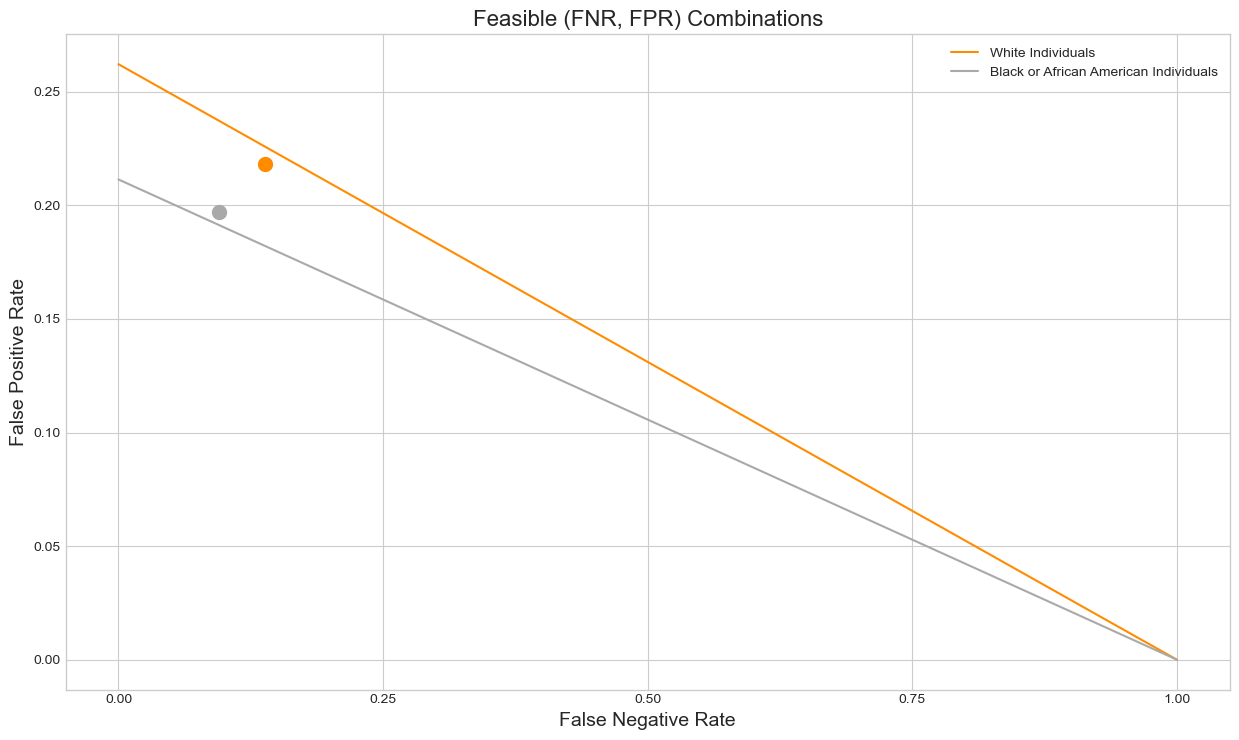

In [36]:
# Defining FPR as linear function of FNR when PPV and P are held constant for white and black or African American individuals in the data
## Calculating P for white and black or African American individuals in the data
p_w = train[train["race"] == 1.0]["emp_status"].sum() / train[train["race"] == 1.0].shape[0]
p_b = train[train["race"] == 2.0]["emp_status"].sum() / train[train["race"] == 2.0].shape[0]

# Pulling PPV for white and black or African American individuals from Table 1
ppv_min = min((race_acc["PPV"].iloc[0] / 100), (race_acc["PPV"].iloc[2] / 100))

# Storing the relevant information in a data frame
fpr_by_fnr = pd.DataFrame(columns = ["FNRW", "FPRW", "FNRB", "FPRB"])
fpr_by_fnr["FNRB"] = np.linspace(0, 1, 100)
fpr_by_fnr["FNRW"] = np.linspace(0, 1, 100)
fpr_by_fnr["FPRB"] = (p_b / (1 - p_b)) * ((1 - ppv_min) / ppv_min) * (1 - fpr_by_fnr["FNRB"])
fpr_by_fnr["FPRW"] = (p_w / (1 - p_w)) * ((1 - ppv_min) / ppv_min) * (1 - fpr_by_fnr["FNRW"])

# # Plotting the FPR as a linear function of FNR
fig, ax = plt.subplots(1, 1, figsize = (12.5, 7.5))
plt.style.use("seaborn-v0_8-whitegrid")

sns.lineplot(fpr_by_fnr, x = fpr_by_fnr["FNRW"], y = fpr_by_fnr["FPRW"], ax = ax, color = "darkorange", label = "White Individuals")
sns.lineplot(fpr_by_fnr, x = fpr_by_fnr["FNRB"], y = fpr_by_fnr["FPRB"], ax = ax, color = "darkgrey", label = "Black or African American Individuals")
ax.scatter(race_acc["FNR"].iloc[2] / 100, race_acc["FPR"].iloc[2] / 100, color = "darkgray", s = 100)
ax.scatter(race_acc["FNR"].iloc[0] / 100, race_acc["FPR"].iloc[0] / 100, color = "darkorange", s = 100)
ax.set_title("Feasible (FNR, FPR) Combinations", fontsize = 16)
ax.set_xlabel("False Negative Rate", fontsize = 14)
ax.set_ylabel("False Positive Rate", fontsize = 14)
ax.set_xticks([(.25 * i) for i in range(5)])

plt.tight_layout()

print(race_acc["FNR"].iloc[0])

*Code above plots FPR as a function of FNR, PPV, and prevalence for individuals identifying as white and those identifying as black or African American.*

**Figure 9**

The plot above is a reproduction of **Figure 5** from Chouldechova's 2017 publication "Fair prediction with disparate impact: A study of bias in recidivism prediction instruments".  For white and black or African American individuals in the data, the plot displays the model's FPR as a linear function of FNR when the prevalence $p$ and PPV are held constant.  Specifically, the function(s) plotted above are:

$$FPR = \frac{p}{1 - p} * \frac{1 - PPV}{PPV} * (1 - FNR)$$


Based on this figure, to tune the refined model to yield equal FPR values for white and black or African American individuals, the model's FNR for white individuals would need to be increased by around 10 percentage points (increasing from what appears to be about $1\%$ to about $27\%$).  This indicates that equalizing FPR values for white and black or African American individuals would require a decrease in the model's accuracy for white individuals.

# Discussion

**1. Groups this model provide benefits to**

There are various different populations in society and the general workforce that could stand to benefit from a predictive system like the one explored in this study.  Consider companies and private organizations seeking to grow capital that are concerned with distributing certain services to individuals who are employed and others to those who aren't.  Some examples of these types of companies include insurance companies (aiming to sell insurance plans to customers), real estate renters (aiming to rent properties to individuals who have reasonable means of paying rent), and banks (aiming to receive profit back from loans repaid by borrowers).  For each of these organizations, it is highly useful to have an accurate prediction of a prospective customer’s employment status as it will have a large impact (often whether or not to sell something at all) on these companies’ business strategies.

**2.  Impact of deploying this model**

The results of my audit show that this model does not operate in strict alignment with several of the primary criteria of statistical “fairness” on the basis of the racial identity of individuals.  Specifically, I found that while this model is moderately calibrated to the enumerated racial groups, it ultimately failed to produce balanced error rates and achieve statistical parity across all racial identities found in the data.  With this, this model’s impact on society following mass deployment and usage could likely involve the propagation of systemic biases and reflection of historical injustices falling on people of certain racial identities.  That is, the mass use of this “unfair” model is likely to produce discriminatory circumstances in most, if not all, of the applications in which it is used.  Whether in commercial, governmental, or public settings, the risk of harm associated with this model may find ways to radiate out into the world.

**3.  Biases in this model**

As touched on above, I feel that the bias audit conducted on this model reveals its exhibition of problematic bias in several ways.  As discussed, the bias audit of this model focused on the model’s “fairness” across race.  From investigating the disparities found in error rates (FPR and FNR – misclassifications of individuals) and the inconsistencies found in the probabilities of “positive” (i.e. “employed”) predictions, I feel that it is reasonable to assert that the model exercises biases through unequal error rates and its lack of statistical parity.  It is important to note, however, that this study only investigates some of the generally accepted metrics of statistical “fairness”.  Additionally, the specific audit processes followed could possibly be re-conducted differently to account for other potentially relevant information such as the proportion of each racial group present in the data.  All this to say, a further and or more thorough examination of bias in this model may show that some of the findings from this analysis hold different levels of significance.

**4.  Additional concerns**

One of my primary concerns with deploying this model traces back to the training data used to construct and refine the model’s behavior.  This model is only trained on data from a single US state.  There is no question that certain characteristics from the training data used will be considerably different from analogous data sets from other states or even other countries.  For example, the racial makeup of Massachusetts is definitively different from that of New York: If the model was trained using ACS PUMS data from New York, it may very well exhibit different behaviors relating to employment status prediction and race.  Additionally, I fear that some of the variable definitions present in the data could be harmful to certain populations of people.  For example, the `SEX` variable is a binary, indicating that all individuals from the data fall into one of two identities for this variable.  But, in greater society, many folks do not identify according to this binary encoding.  That is, I am concerned with the generalization implied by the design of some of the variables used in this data and how it could have a constructive effect on specific people – This negative effect may manifest further through intersectional biases exhibited by the model.  To address these concerns, I would propose that this model be trained on and designed to process many different data sets; including multiple from the data source initially used in addition to data collected from entirely different sources.  I recognize that this data set diversification will likely add considerable complexity to the model designing and refining processes.  However, I feel that the trade-off in construction simplicity for a more holistic, fair-leaning model is well worth it.

*During the implementation process of this replication study, I collaborated with Omar Armbruster.*